In [1]:
import pandas as pd
from nltk.stem import PorterStemmer
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import numpy as np
from numpy.linalg import norm
from nltk.cluster import KMeansClusterer
from nltk.cluster.util import cosine_distance
import gensim

## Read corpus and preprocess

For faster processing time, read the pickled corpora from files.

In [2]:
ir_data = pd.read_csv('ir_data_final.txt', delimiter='\t')

In [3]:
# report_corpus = ir_data.groupby('ir_date')['paragraph']\
#                 .apply(" ".join).to_frame().rename(columns=dict(paragraph='report'))
# paragraph_corpus = ir_data[['ir_date', 'paragraph']].copy()
# # Generate sentence-level corpus
# sentence_corpus = pd.DataFrame({'ir_date': paragraph_corpus.ir_date,
#                                 'sentences': paragraph_corpus.paragraph.apply(sent_tokenize)})

In [4]:
# # Preprocess
# ps = PorterStemmer()
# sw = stopwords.words('english')
# def mypreprocess(text):
#     #text is a document of a corpus
#     #lowercase of text
#     text=text.lower()
#     #remove all the irrelevant numbers and punctuation
#     text=re.sub(r'[^a-z]+',' ',text)
#     #tokenize the words
#     token1=word_tokenize(text)
#     #remove the meaningless stopping words
#     token2=[t for t in token1 if t not in sw]
#     #stemming transformation
#     token3=[ps.stem(t) for t in token2]
#     return token3

In [5]:
# # Takes time, about 26s
# report_corpus['clean_report'] = report_corpus.report.apply(lambda x: ' '.join(mypreprocess(x)))

In [6]:
# # Takes time, about 28s
# paragraph_corpus['clean_paragraph'] = paragraph_corpus.paragraph.apply(lambda x: ' '.join(mypreprocess(x)))

In [7]:
# # Take time, about 32s
# # Clean sentences by sentences
# sentence_corpus['clean_sentences'] = sentence_corpus.sentences.apply(lambda ss: [mypreprocess(x) for x in ss])

In [8]:
# with open('report_corpus.pkl', 'wb') as f:
#     pickle.dump(report_corpus, f)
# with open('paragraph_corpus.pkl', 'wb') as f:
#     pickle.dump(paragraph_corpus, f)
# with open('sentences_corpus.pkl', 'wb') as f:
#     pickle.dump(sentence_corpus, f)

Load pickled data directly the next time

In [9]:
# Load cached report-level corpus
with open('report_corpus.pkl', 'rb') as f:
    report_corpus = pickle.load(f)

In [10]:
# Load cached paragraph-level corpus
with open('paragraph_corpus.pkl', 'rb') as f:
    paragraph_corpus = pickle.load(f)

In [11]:
# Load cached sentence-level corpus
with open('sentences_corpus.pkl', 'rb') as f:
    sentence_corpus = pickle.load(f)

## Latent Semantic Analysis (LSA)
Compute `tf-idf` **document term frequency** matrix.
- **Analyze with report-level corpus first**

In [12]:
vectorizer = TfidfVectorizer(min_df=0.1, stop_words=stopwords.words('english'))
tfidf_obj = vectorizer.fit_transform(report_corpus.clean_report)
X = tfidf_obj.toarray()
print(X.shape)

(70, 2284)


In [13]:
vectorizer.get_feature_names()[:10]

['abat',
 'abil',
 'abl',
 'abnorm',
 'abolit',
 'abroad',
 'abrupt',
 'absenc',
 'absent',
 'absolut']

Use Singular Value Decomposition (SVD) to obtain LSA components

In [14]:
A, sigma, B_T = np.linalg.svd(X)

The reduced dimensionality parameter $k$

In [15]:
k = 10
# k = 2

In [16]:
D = X.shape[0]
V = X.shape[1]
major_N = min(D, V)
Sigma = np.zeros(shape=(D, V))
Sigma[:major_N, :major_N] = np.diag(sigma) 

In [17]:
# Reduced Sigma matrix
Sigma_k = np.copy(Sigma)
# Set diagonal entries other than the first k as zero
Sigma_k[k:major_N, k:major_N] = 0

In [18]:
# Total variance explained by order k
vars_explained = np.square(sigma) / np.sum(np.square(sigma))
print(f'Variance explained by rank {k} approximation:')
print('{:.2f}%'.format(100 * np.sum(vars_explained[:k])))

Variance explained by rank 10 approximation:
93.71%


In [19]:
import matplotlib.pyplot as plt
plt.plot(np.cumsum(vars_explained));
plt.xlabel('Rank k approxiamtion');
plt.ylabel('Total variance explained');

In [20]:
# Compute low-dimension vectors representation of terms
term_vectors_k = np.dot(Sigma_k, B_T)

In [21]:
# Cosine similarities matrix of columns vectors
def cos_sim(a, b):
    return np.dot(a, b) / (norm(a) * norm(b))
cos_sim_matrix = np.zeros(shape=(term_vectors_k.shape[1], term_vectors_k.shape[1]))
for c_idx1 in range(term_vectors_k.shape[1]):
    for c_idx2 in range(term_vectors_k.shape[1]):
        c1 = term_vectors_k[:, c_idx1]
        c2 = term_vectors_k[:, c_idx2]
        cos_sim_matrix[c_idx1, c_idx2] = cos_sim(c1, c2)    

In [22]:
# 2284 terms, cross cosine similarity
cos_sim_matrix.shape

(2284, 2284)

In [23]:
term_names = vectorizer.get_feature_names()
inflation_sim = pd.DataFrame(index=term_names,
                             data={'Cosine Similarity':cos_sim_matrix[:, term_names.index('inflat')]})
inflation_sim = inflation_sim.sort_values(by='Cosine Similarity', ascending=False)

In [24]:
inflation_sim.iloc[:10, ]

,Cosine Similarity
inflat,1.000000
determin,0.997507
factor,0.995946
also,0.992158
make,0.989071
impli,0.988861
import,0.988763
increas,0.988342
reflect,0.987038
follow,0.986896


### **Analyze with paragraph-level corpus**
Unlike with the report-level corpus, for paragraphs, we reduced the minimum document frequency threshold to 0.01. This ends up with a 701-term feature space.

In [25]:
vectorizer = TfidfVectorizer(min_df=0.01, stop_words=stopwords.words('english'))
tfidf_obj = vectorizer.fit_transform(paragraph_corpus.clean_paragraph)  # Paragraph
X = tfidf_obj.toarray()
print(X.shape)

(15023, 701)


In [26]:
vectorizer.get_feature_names()[:10]

['abil',
 'abl',
 'abroad',
 'access',
 'accord',
 'account',
 'across',
 'act',
 'activ',
 'actual']

Use Singular Value Decomposition (SVD) to obtain LSA components

In [27]:
# Takes time, about 18s
A, sigma, B_T = np.linalg.svd(X)

The reduced dimensionality parameter $k$

In [28]:
k = 10
# k = 2

In [29]:
D = X.shape[0]
V = X.shape[1]
major_N = min(D, V)
Sigma = np.zeros(shape=(D, V))
Sigma[:major_N, :major_N] = np.diag(sigma) 

In [30]:
# Reduced Sigma matrix
Sigma_k = np.copy(Sigma)
# Set diagonal entries other than the first k as zero
Sigma_k[k:major_N, k:major_N] = 0

Variance explained by `k=10` approximation is much lower.

In [31]:
# Total variance explained by order k
vars_explained = np.square(sigma) / np.sum(np.square(sigma))
print(f'Variance explained by rank {k} approximation:')
print('{:.2f}%'.format(100 * np.sum(vars_explained[:k])))

Variance explained by rank 10 approximation:
19.28%


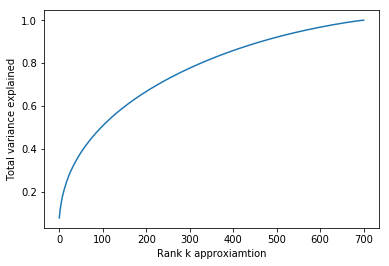

In [32]:
import matplotlib.pyplot as plt
plt.plot(np.cumsum(vars_explained));
plt.xlabel('Rank k approxiamtion');
plt.ylabel('Total variance explained');

In [33]:
# Compute low-dimension vectors representation of terms
term_vectors_k = np.dot(Sigma_k, B_T)

In [34]:
# Compute similarities againts inflat
def cos_sim(a, b):
    return np.dot(a, b) / (norm(a) * norm(b))

inflat_vector = term_vectors_k[:, vectorizer.get_feature_names().index('inflat')]
sim_against_inflat = []
for c_idx in range(term_vectors_k.shape[1]):
    sim_against_inflat.append(cos_sim(term_vectors_k[:, c_idx], inflat_vector))

inflation_sim = pd.DataFrame(data={'term': vectorizer.get_feature_names(),
                                  'similarity': sim_against_inflat})\
                        .sort_values(by='similarity', ascending=False)

In [35]:
inflation_sim.head(10)

,term,similarity
295,inflat,1.000000
121,cpi,0.981362
626,target,0.938470
673,vat,0.890062
541,rpix,0.889457
168,drop,0.873432
156,diminish,0.859187
93,comparison,0.850554
672,variou,0.846415
368,medium,0.842093


Observation: we might assert that paragraph-level corpus actually yields a better similarity analysis than report-level corpus. It sucessfully identifies similar terms of 'inflat', such as 'cpi', 'target', 'VAT' and 'RPIX'.

Note: **'RPIX'** is measure of inflation in United Kingdom. It stands for *Retail Price Index (RPI) excluding mortgage interest payments*. [Wikipedia](https://en.wikipedia.org/wiki/RPIX)

### K-mean Clustering on paragraph-level corpus

In [36]:
N_cluster = 5
kmc = KMeansClusterer(N_cluster, distance=cosine_distance, repeats=25)

Note that we strip out zeros in the bottom of `term_vectors_k` simply for convience in this step. This doesn't affect anything because the bottom zeros don't contribute anything to the more-than-k dimensionalities.
Recall that `term_vectors_k`=$\Sigma_kB^T_k$, whose $V$ column vectors in $\mathcal{R^k}$ correspond to $V$ terms' lower-dimension representations.

In [37]:
# Strip out the lower zeros in term vectors 
cr = kmc.cluster(term_vectors_k[:k, :].T, assign_clusters=True)

In [38]:
term_topic_assignment = pd.DataFrame({'term': vectorizer.get_feature_names(),
                                     'topic': cr}).sort_values(by='topic').set_index('topic')

In [39]:
term_topic_assignment

,term
topic,
0,lowest
0,employe
0,employ
0,earn
0,recruit
...,...
4,date
4,save
4,scheme


## `word2vec`
Try different windows
### CBOW version

In [40]:
sentences = [sent for sents in sentence_corpus.clean_sentences for sent in sents]

In [41]:
CBOW = gensim.models.Word2Vec(sentences,
                              sg=0, # CBOW
                              min_count=3,  # Ignore words that appear less than this
                              size=200,  # Dimensionality of word embeddings
                              workers=2,  # Number of processors (parallelisation)
                              window=5,  # Context window for words during train
                              iter=30)

The word-embedding vector of "inflat"

In [42]:
CBOW.wv['inflat'].shape

(200,)

In [43]:
CBOW.wv.most_similar('inflat')

[('rpix', 0.45503315329551697),
 ('cpi', 0.37930798530578613),
 ('petrol', 0.3643169403076172),
 ('energi', 0.3510257601737976),
 ('price', 0.3495141863822937),
 ('target', 0.3207089900970459),
 ('inflationari', 0.3105059862136841),
 ('rpi', 0.3075481951236725),
 ('food', 0.2826911211013794),
 ('remaind', 0.2790200114250183)]

Now vary the window length to 10

In [44]:
sentences = [sent for sents in sentence_corpus.clean_sentences for sent in sents]

In [45]:
CBOW = gensim.models.Word2Vec(sentences,
                              sg=0, # CBOW
                              min_count=3,  # Ignore words that appear less than this
                              size=200,  # Dimensionality of word embeddings
                              workers=2,  # Number of processors (parallelisation)
                              window=10,  # Context window for words during train
                              iter=30)

The word-embedding vector of "inflat"

In [46]:
CBOW.wv['inflat'].shape

(200,)

In [47]:
CBOW.wv.most_similar('inflat')

[('rpix', 0.4332500696182251),
 ('price', 0.36934417486190796),
 ('energi', 0.36805403232574463),
 ('petrol', 0.36696740984916687),
 ('inflationari', 0.3286275863647461),
 ('cpi', 0.3263664245605469),
 ('food', 0.3195022642612457),
 ('util', 0.3039674758911133),
 ('interplay', 0.2986896336078644),
 ('commod', 0.29155588150024414)]

Observation: after increasing the window length to 10, we found that the top 6 similar words of 'inflat' are almost unchanged. They are simply shuffled in order.

### Skip-gram version

In [48]:
SKIP = gensim.models.Word2Vec(sentences,sg=1, # skip-gram
                              min_count=3,  # Ignore words that appear less than this
                              size=200,  # Dimensionality of word embeddings
                              workers=2,  # Number of processors (parallelisation)
                              window=5,  # Context window for words during train
                              iter=30)

In [49]:
SKIP.wv['inflat'].shape

(200,)

The top 10 similar words of "inflat", and similarities.

In [50]:
SKIP.wv.most_similar('inflat')

[('cpi', 0.5825357437133789),
 ('rpix', 0.5583981275558472),
 ('target', 0.5347272157669067),
 ('price', 0.4585423469543457),
 ('symmetr', 0.4221271276473999),
 ('interplay', 0.4203638434410095),
 ('reportwa', 0.4097006618976593),
 ('somewher', 0.4080858528614044),
 ('dislodg', 0.39702609181404114),
 ('rpi', 0.39686882495880127)]

Now vary the window length to 10

In [51]:
SKIP = gensim.models.Word2Vec(sentences,sg=1, # skip-gram
                              min_count=3,  # Ignore words that appear less than this
                              size=200,  # Dimensionality of word embeddings
                              workers=2,  # Number of processors (parallelisation)
                              window=10,  # Context window for words during train
                              iter=30)

In [52]:
SKIP.wv['inflat'].shape

(200,)

The top 10 similar words of "inflat", and similarities.

In [53]:
SKIP.wv.most_similar('inflat')

[('cpi', 0.6412736773490906),
 ('target', 0.6014261841773987),
 ('rpix', 0.5998241901397705),
 ('price', 0.5153356790542603),
 ('setter', 0.4203907251358032),
 ('horizon', 0.41435688734054565),
 ('interplay', 0.40517517924308777),
 ('inflationari', 0.38848698139190674),
 ('beverag', 0.3856521248817444),
 ('petrol', 0.3847038149833679)]

Observation: for the skip-gram algorithm version of `word2vec`, we might say that increasing window length helps searching for similar terms. We can identify more relevant term of 'inflat in this prolonged model.

## Vector representation of sentences

Use Algorithm 1 in paper by Arora et al. (2017) to convert a word embedding to a sentence embedding.

Here we used the first report on February, 1998 as the corpus, constructed SIF-weighted embedding for each sentence in the report.

In [54]:
# Select the first report
first_report = sentence_corpus.query('ir_date == 199802')
report199802_sentences = [sent for sentences in first_report.clean_sentences for sent in sentences]
report199802_sentences_raw = [sent for sentences in first_report.sentences for sent in sentences]

In [55]:
# Fit another CBOW model in the sentence in the first report
CBOW = gensim.models.Word2Vec(report199802_sentences,sg=0, # CBOW
                              min_count=3,  # Ignore words that appear less than this
                              size=200,  # Dimensionality of word embeddings
                              workers=2,  # Number of processors (parallelisation)
                              window=5,  # Context window for words during train
                              iter=30)

In [56]:
def word2sent_embedding(sentences, raw_sentences, w2v, alpha=0.001):
    vocab = w2v.wv.vocab  # Keep track of all unique words in model
    w_embedding = w2v.wv  # Embedding vectors of words
    N = 0  # Total word cout in corpus
    K = w2v.vector_size  # Dimension of word-embedding vectors
    for v in vocab:
        N += vocab[v].count
    
    X = []  # Placeholder for sentence embedding
    sents = []  # Placeholder for qualified raw senetences (untokenized)
    for i, sent in enumerate(sentences):
        if len(sent) == 0:  # no token in sentences
            continue
        v = np.zeros(shape=K)
        for word in sent:
            valid_word_count = 0
            if word in vocab:  # Some words are removed
                valid_word_count += 1
                v += (alpha / (alpha+vocab[word].count/N)) * w_embedding[word]
        # Normalize by the length of the sentence
        if valid_word_count == 0:
            continue
        v /= valid_word_count
        X.append(v)
        sents.append(raw_sentences[i])
    
    X_mat = np.array(X)  # K
    # Remove common component
    _, _, Vh = np.linalg.svd(X_mat)
    V = Vh.T  # Columns are principal components of term embedding space (dimension R K)
    assert V.shape[0] == K
    u = V[:, 0].reshape(-1, 1)  # Force the first singular vector to be a column vector
    for i in range(len(X)):
        vs = X[i].reshape(-1, 1)
        X[i] = (vs - np.dot(np.dot(u, u.T), vs)).reshape(-1)
    
    return sents, X

In [57]:
sents, sent_embeddings = word2sent_embedding(report199802_sentences,
                                             report199802_sentences_raw,
                                             CBOW)

In [58]:
sent_embeddings[0].shape

(200,)

### Cluster the sentence embedding using K-means algorithm

In [59]:
N_cluster = 10  # 10 topics
kmc = KMeansClusterer(N_cluster, distance=cosine_distance, repeats=25)
cr = kmc.cluster(sent_embeddings, assign_clusters=True)

In [60]:
sentence_cluster = pd.DataFrame(data={'sentence': sents,
                  'topic': cr}).sort_values(by='topic').set_index('topic')

In [95]:
print(sentence_cluster)

                                                sentence
topic                                                   
0      Since then, output has risen at an average rat...
0      The largest change was to cyclical social secu...
0      The preliminary estimate of real GDP in 1997 Q...
0      These data were published after the preliminar...
0      Real GDP grew by 3.3% in 1997, the sixth year ...
0      Revisions to real GDP data for 1997 Q3 and the...
0      Average earnings growth was 43/4% in the twelv...
0      At 6.6% of the workforce, it was 1.3 percentag...
0      Longer-term inflation expectations can also be...
0      The Pre-Budget Report on 25 November revised d...
0      The Government announced in January this year ...
0      The prices of imported goods in the three mont...
0      On 4 February, the date on which data for this...
0      Though most of this fall occurred at the start...
0      This was much higher than in the previous thre...
0      Annual output price infl

In [62]:
def write_topic(t, f):
    f.write('-'*8 + str(t.index[0])+'-'*8 + '\n')
    for sentence in t.sentence:
        f.write(sentence+'\n')
with open('sentence_clustering_199802.txt', 'w') as f:
    sentence_cluster.groupby('topic').apply(lambda t: write_topic(t, f))

In [63]:
sentence_cluster.to_excel('sentence_clustering_199802.xlsx')

Observation: the clusters obtained from the analysis above have been built based on sentiment and topic. The results give us insights about the different elements that have been impacted by inflation such as 
- GDP and overall economic growth (topic 0)
- Fall of commodities prices, rise of house price and  decrease of unemployment (topic 1)
- Broad money growth (topic 2)
- Consumption rate and currency exchange (topic 3)
- Manufacturers' employment, loan markets (topic 4)
- Import and export of goods (topic 5)
- House price index (topic 6)
- Global economy (topic 7)
- Interest rates (topic 8)
- Domestic and Foreign demand (topic 9)

## Construct an economic sentiment indicator

We have dozens of inflation reports of the U.K. from 1998 to 2015. First, we separate them in two sets, one in rising inflation, one in falling inflation.

In [64]:
ir_data.ir_date.unique()

array([199802, 199805, 199808, 199811, 199902, 199905, 199908, 199911,
       200002, 200005, 200008, 200011, 200102, 200105, 200108, 200111,
       200202, 200205, 200208, 200211, 200302, 200305, 200308, 200311,
       200402, 200405, 200408, 200411, 200502, 200505, 200508, 200511,
       200602, 200605, 200608, 200611, 200702, 200705, 200708, 200711,
       200802, 200805, 200808, 200811, 200902, 200905, 200908, 200911,
       201002, 201005, 201008, 201011, 201102, 201105, 201108, 201111,
       201202, 201205, 201208, 201211, 201302, 201305, 201308, 201311,
       201402, 201405, 201408, 201411, 201502, 201505], dtype=int64)

Collect the following economic state indicators:
- quarterly growth rate of *CPIH* (Consumer Prices Index including owner occupiers' housing costs) to classify reporting period into accelerating inflation and decelerating inflation.
- quarterly growth rat eof *GDP* in the United Kingdom

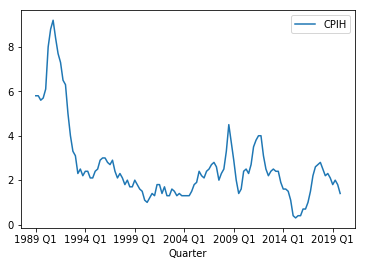

In [65]:
# Load CPIH index quarterly change rate series
inflation_gr = pd.read_csv('CPIH.csv').set_index('Quarter')
inflation_gr.plot();

In [66]:
inflat_bool_series = (inflation_gr.diff().dropna() > 0).rename(columns={"CPIH": 'Accl'})  # Second order
inflat_bool_series

,Accl
Quarter,
1989 Q2,False
1989 Q3,False
1989 Q4,True
1990 Q1,True
1990 Q2,True
...,...
2018 Q4,False
2019 Q1,False
2019 Q2,True


We picked a specific cutoff rate for quarterly GDP growth, in order to classify the report into two states.

In [67]:
gdp = pd.read_csv('GDP_Q_season_adjed.csv')
gdp['GDP_gr'] = gdp.GDP.pct_change()*100
gdp = gdp.set_index('Quarter').dropna()

GDP_Q_GR_CUTOFF = 0.5  # 0.5% quarterly growth rate as partiton cutoff
gdp['Pos_gr'] = gdp.GDP_gr > GDP_Q_GR_CUTOFF

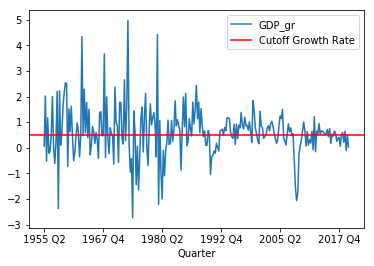

In [68]:
gdp.GDP_gr.plot();
plt.axhline(y=GDP_Q_GR_CUTOFF, c='r', label='Cutoff Growth Rate')
plt.legend();

In [69]:
gdp

,GDP,GDP_gr,Pos_gr
Quarter,,,
1955 Q2,112267,0.065066,False
1955 Q3,114538,2.022856,True
1955 Q4,113938,-0.523844,False
1956 Q1,115274,1.172568,True
1956 Q2,115024,-0.216875,False
...,...,...,...
2018 Q4,518136,0.214108,False
2019 Q1,521458,0.641144,True
2019 Q2,520893,-0.108350,False


In [70]:
def ir_date_economic_state(ir_date, eco_state_series):
    """
    :param eco_state_series, should be a series of quartely-dated booleans
    indicating in or not in certain economic condition
    """
    ir_date = str(ir_date)
    year = ir_date[:4]
    month = int(ir_date[4:])
    key = year + ' Q'
    if month < 4:
        key += '1'  # Q1
    elif month < 7:
        key += '2'  # Q2
    elif month < 10:
        key += '3'  # Q3
    elif month < 13:
        key += '4'  # Q4
    else:
        raise ValueError('Invalid quarter')
    
    return eco_state_series.loc[key]

### Split Corpus into inflation accelerating / decelerating

In [71]:
# Fetch the sentence_corpus, and decide the group assignment for each sentences
sentence_corpus['Accl_inflat'] = sentence_corpus.ir_date\
            .apply(lambda t: ir_date_economic_state(t, inflat_bool_series))
# Reports during when inflation is accelerating
accl_inflat_corpus = sentence_corpus.query('Accl_inflat == True')
# Reports during when inflation is decelerating
decl_inflat_corpus = sentence_corpus.query('Accl_inflat == False')
accl_inflat_corpus.shape, decl_inflat_corpus.shape

((6333, 4), (8690, 4))

### Split Corpus into GDP quarterly increase / decline

In [72]:
sentence_corpus['GDP_q_incr'] = sentence_corpus.ir_date\
            .apply(lambda t: ir_date_economic_state(t, gdp.Pos_gr))
pos_gr_corpus = sentence_corpus.query('GDP_q_incr == True')
neg_gr_corpus = sentence_corpus.query('GDP_q_incr == False')

In [73]:
pos_gr_corpus.shape, neg_gr_corpus.shape

((9639, 5), (5384, 5))

### Estimate two separate `word2vec` models
One for each set of documents

In [74]:
def fit_CBOW_model(corpus):
    sents = [sent for sents in corpus.clean_sentences for sent in sents]
    return gensim.models.Word2Vec(sents,
                                   sg=0, # CBOW
                                   min_count=3,  # Ignore words that appear less than this
                                   size=200,  # Dimensionality of word embeddings
                                   workers=2,  # Number of processors (parallelisation)
                                   window=5,  # Context window for words during train
                                   iter=30)

In [75]:
# Load the "increase" set and "decrease" set
attr_words = pd.read_csv('attribute_words.csv')
I = tuple(attr_words.word[attr_words.increase == 1])
D = tuple(attr_words.word[attr_words.decrease == 1])
# Stem the words
ps = PorterStemmer()
I = tuple(set(ps.stem(i) for i in I))
D = tuple(set(ps.stem(d) for d in D))

In [76]:
# vocab = list(CBOW_accl.wv.vocab.keys()) + list(CBOW_decl.wv.vocab.keys())
# vocab = sorted(set(vocab))
# pd.Series(data=vocab).to_csv('vocabs.csv')

Construct a set of words $X$ which reflects a particular economic concept that should vary across your two Report groups. We picked a set of words to reflect the general economic condition and stage in business cycle.

In [77]:
X = ('gdp', 'activ', 'macroeconom', 'market', 'financ', 'financi', 'growth')

Class to implement the IR_Sentiment index

In [78]:
class IR_Sent:
    def __init__(self, w2v_model, I, D, X):
        self.w2v = w2v_model  # The fitted word2vec model
        vocab = w2v_model.wv.vocab
        # Look up word-embedding vectors for words in I, D, X
        # Ensure the words is in word2vec vocabulary
        I = [i for i in I if i in vocab]
        D = [d for d in D if d in vocab]
        print('I:', len(I), 'D:', len(D))
        self.I = tuple(w2v_model.wv[i] for i in I)  # Positive term set
        self.D = tuple(w2v_model.wv[d] for d in D)  # Negative term set
        self.X = tuple(w2v_model.wv[x] for x in X)  # Target term set
    
    @staticmethod
    def cos(x, y):
        return np.dot(x, y) / (norm(x) * norm(y))
    
    @staticmethod
    def s(w, A, B):
        return np.mean([IR_Sent.cos(w, a) for a in A]) - np.mean([IR_Sent.cos(w, b) for b in B])
    
    def score(self):
        sarr = [IR_Sent.s(x, self.I, self.D) for x in self.X]
        return np.sum(sarr) / np.std(sarr)

### Sentiment Index on partition (Inflation accelerating?) 

In [79]:
CBOW_accl = fit_CBOW_model(accl_inflat_corpus)
CBOW_decl = fit_CBOW_model(decl_inflat_corpus)

In [80]:
print('Decelerating Inflation Sentiment index:', IR_Sent(CBOW_decl, I, D, X).score())

I: 19 D: 23
Decelerating Inflation Sentiment index: 3.2389166


In [81]:
print('Accelerating Inflation Sentiment index:', IR_Sent(CBOW_accl, I, D, X).score())

I: 19 D: 23
Accelerating Inflation Sentiment index: 0.68817234


### Sentiment Index on partition (quarterly GDP  increasing?)

In [82]:
CBOW_gq_incr = fit_CBOW_model(pos_gr_corpus)
CBOW_gq_decr = fit_CBOW_model(neg_gr_corpus)

In [83]:
IR_Sent(CBOW_gq_incr, I, D, X).score()

I: 19 D: 23


7.780101

In [84]:
IR_Sent(CBOW_gq_decr, I, D, X).score()

I: 18 D: 23


-5.6807203

Observation:
The sentiment index we constructed is
- *positive* for the expansion report corpus (quarterly GDP growth rate > CUTOFF rate)
- *negative* for the recession report corpus (quarterly GDP growth rate <= CUTOFF rate)

The cutoff rate is set to 0.5% to achieve two approximately equally-sized corpus.

The result is in line with our expectation: When the economy is in expansion phase, we expect general economic terms like "GDP" and "Macroeconomy" to bind more closely to the positive attribute word set $I$, rather than the negative attribute word set $D$. When the economy is in recession phase, vice versa.